# Bikes

In [2]:
import arviz as az
import bambi as bmb
import kulprit as kpt
import pandas as pd

In [ ]:
RANDOM_SEED = 8457
rng = np.random.RandomState(RANDOM_SEED)
az.style.use("arviz-white")
plt.rcParams["figure.dpi"] = 300

In [ ]:
bikes = pd.read_csv("bikes.csv")

data = bikes[["count", "hour", "temperature", "humidity", "windspeed"]]

In [ ]:
model = bmb.Model("count ~ hour + temperature + humidity + windspeed", data=data)
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, hour, temperature, humidity, windspeed, count_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [ ]:
ref_model = kpt.ReferenceModel(model, idata)
ref_model.search()

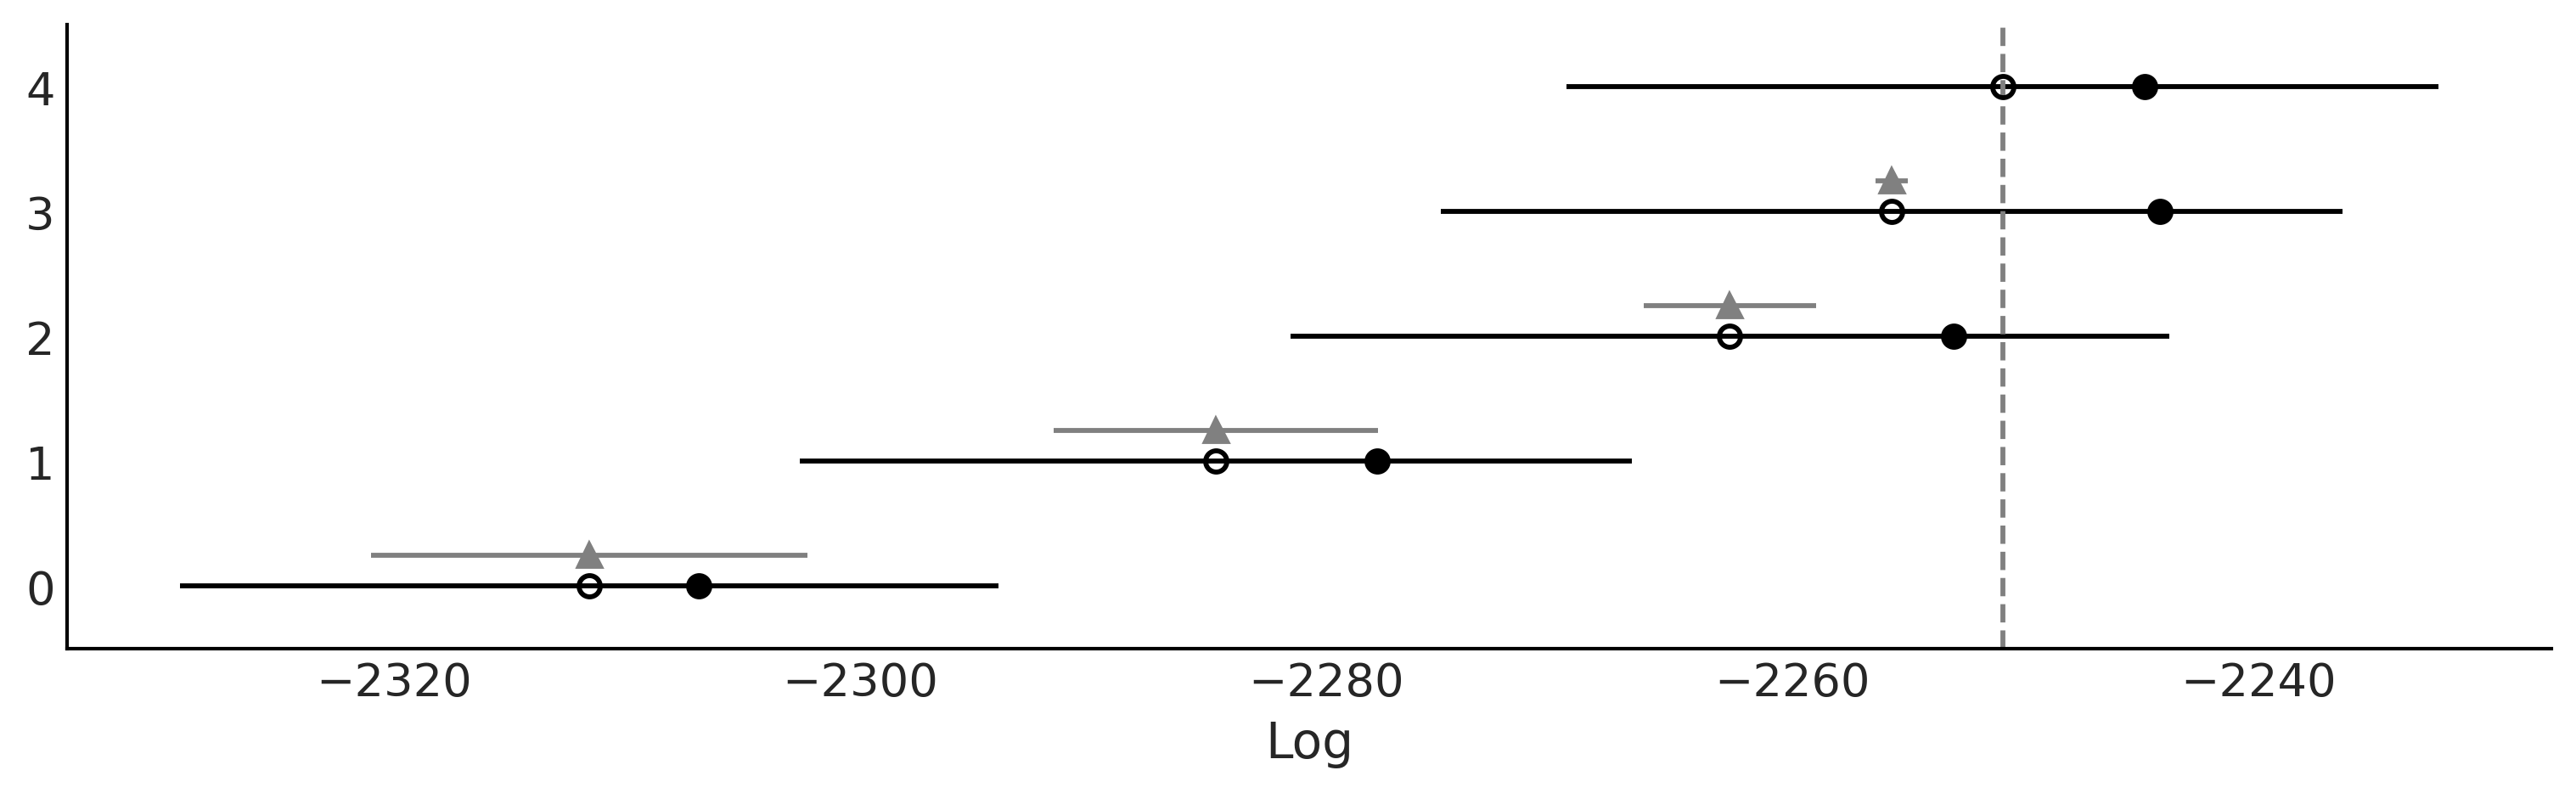

In [ ]:
cmp, ax = ref_model.loo_compare(plot=True, plot_kwargs={"figsize":(10, 3)});